## Derivatives Pricing

The goal is to perform derivative pricing from a machine learning standpoint and use supervised regression based model to learn Black-Scholes option pricing model from simulated data

# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing problem is defined in the regression framework, where the predicted variable is the pricing of the option, and the predictor variables are the market data that are used as inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

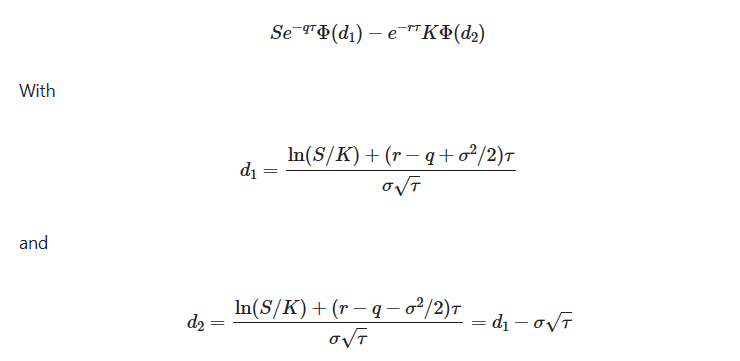

 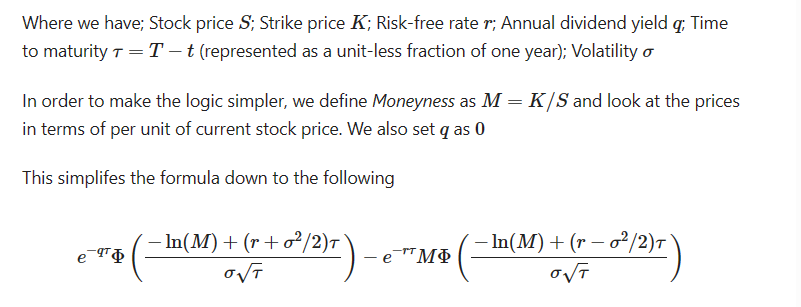



## Vol Surface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

# Simulation

In this exercise, we assume the the sturcture of the vol surface. In practice, we would source the data from a data vendor.

We use the following function to generate the option volatility surface



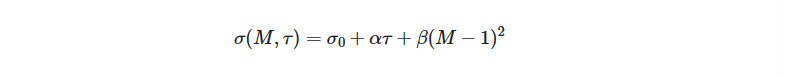

# 2. Loading packages

## 2.1 Python imports

In [83]:






from scipy.stats import norm
## Libraries general
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Training Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score , GridSearchCV

## Algorithm lib
from sklearn.linear_model import LinearRegression,Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

## Libraries for Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor

import statsmodels.api as sm

from pickle import dump
from pickle import load

## time series models
from statsmodels.tsa.arima_model import ARIMA

## Error Metrics
from sklearn.metrics import mean_squared_error

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

##Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 2.2. Defining functions and parameters 

In [30]:
true_alpha =0.1
true_beta=0.1
true_sigma0=0.2

In [31]:
risk_free_rate =0.05

In [32]:
## Vol and option pricing functions

In [33]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 +true_alpha *time_to_maturity+ true_beta*np.square(moneyness-1)
def call_option_price(moneyness, time_to_maturity, option_vol):
    d1 =(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2 =(np.log(1/moneyness)-(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))  
    N_d1 =norm.cdf(d1)
    N_d2 =norm.cdf(d2)
    
    return N_d1-moneyness*np.exp(-risk_free_rate*time_to_maturity) *N_d2

# 2.3. Data Generation

In [34]:
N=10000
Ks =1+0.25*np.random.randn(N)
Ts=np.random.random(N)
Sigmas =np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps= np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

## Set the Endog and Exog Data

In [35]:
Y= Ps
X= np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1),Sigmas.reshape(-1,1)], axis=1)


dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

# 3. Exploratory Data Analysis

In [36]:
## 3.1 Descriptive stats

In [37]:
dataset.head()

,Price,Moneyness,Time,Vol
0,0.157581,0.925614,0.480819,0.248635
1,0.253474,0.804239,0.749972,0.278829
2,0.160585,0.978846,0.931876,0.293232
3,0.111562,1.084257,0.847812,0.285491
4,0.000004,1.550539,0.166435,0.246953


In [38]:

dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.152709,0.996613,0.492536,0.255432
std,0.135791,0.248546,0.289410,0.030113
min,-0.010674,0.031381,0.000018,0.200073
25%,0.049364,0.827472,0.241699,0.229911
50%,0.119051,0.998083,0.490656,0.255407
75%,0.219718,1.167446,0.742443,0.280634
max,0.969771,1.966708,0.999957,0.374729


## 3.2 Data Visualizaton

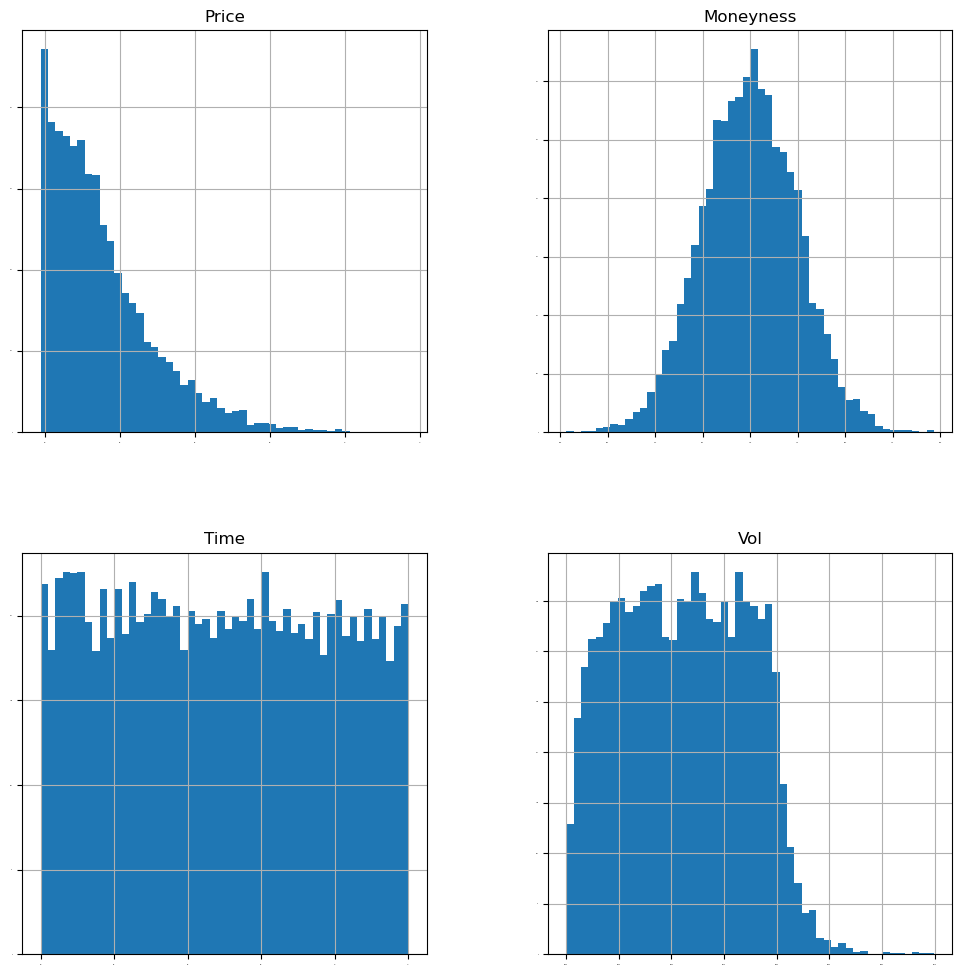

In [39]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1,ylabelsize=1, figsize=(12,12))
pyplot.show()

We can see that the price has an interesting distribution with a spike at 

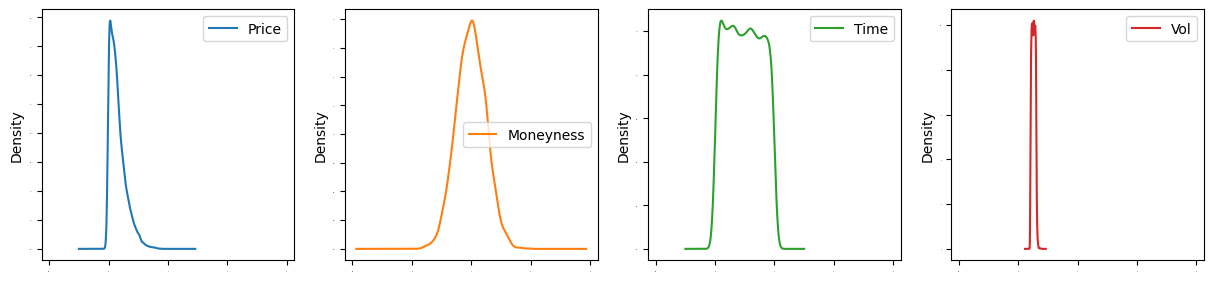

In [40]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True,fontsize=1, figsize=(15,15))
pyplot.show()


Next we look at the interaction between different variables

<Axes: title={'center': 'Correlation Matrix'}>

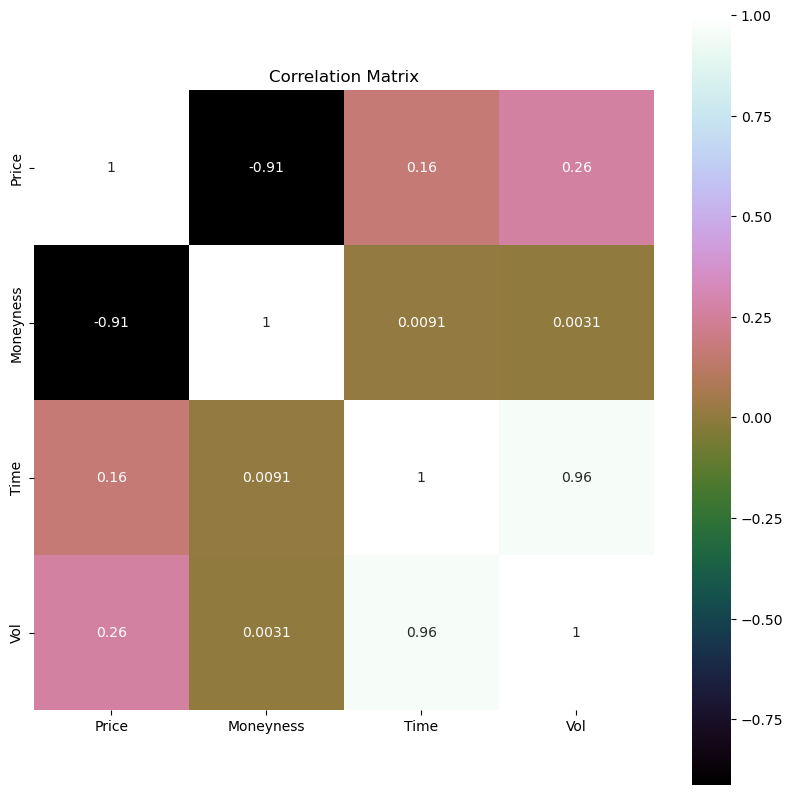

In [41]:
correlation =dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1,square=True,annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

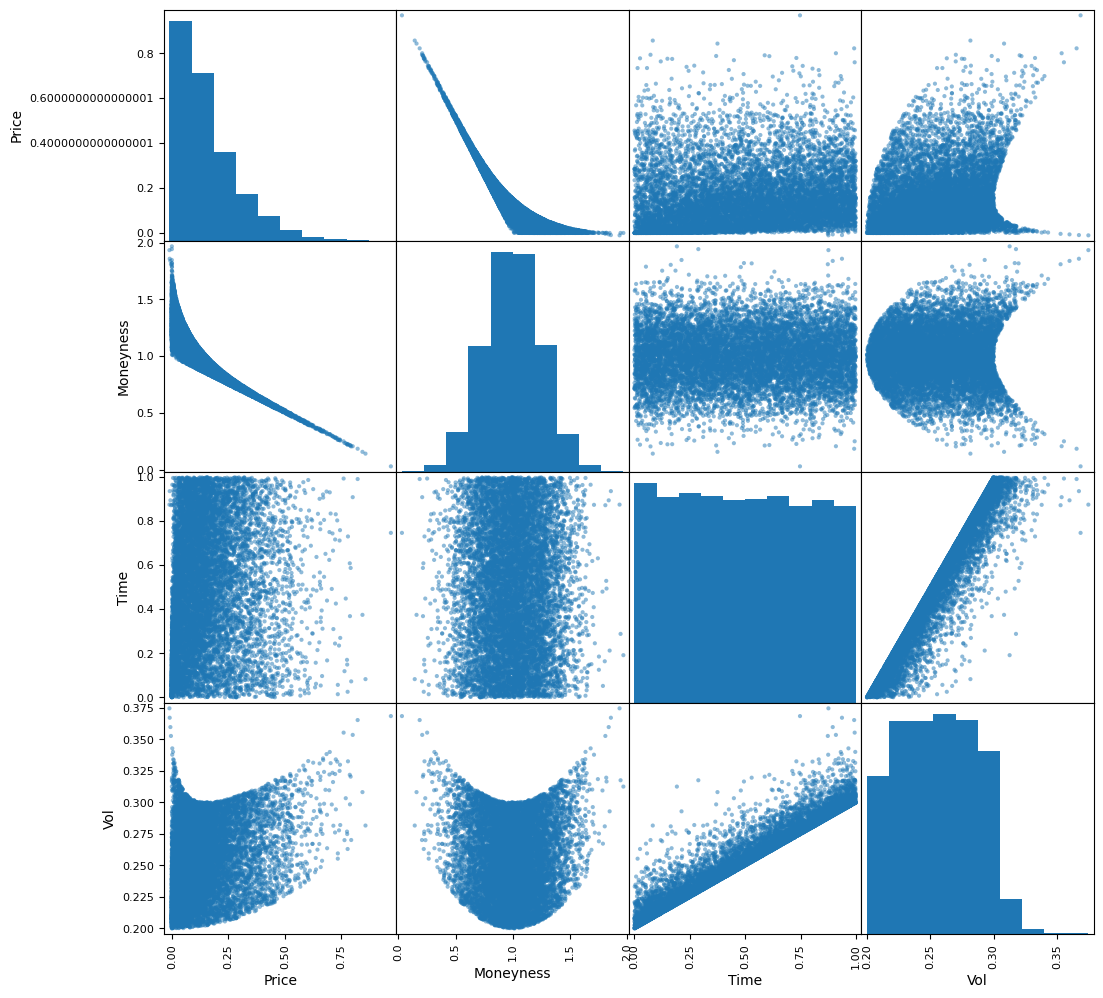

In [42]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(12,12))
pyplot.show()


We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

# 4 Data Preparation and Analysis

## 4.1. Univariate Feature Selection

In [46]:
bestfeatures =SelectKBest(k='all' ,score_func= f_regression)
fit =bestfeatures.fit(X,Y)
dfscores =pd.DataFrame(fit.scores_)
dfcolumns =pd.DataFrame(['Moneyness','Time', 'Vol'])
featuresScores =pd.concat([dfcolumns,dfscores] ,axis=1)
featuresScores.columns =['Specs', 'Score']
featuresScores.nlargest(10,'Score').set_index('Specs')

,Score
Specs,
Moneyness,50588.516927
Vol,751.347623
Time,275.831685


 We observe that the moneyness is the most important variable for the price

# 5. Evaluate Algorithms and Models

## 5.1 Train test split and evaluation metrics

In [51]:
validation_size =0.2
train_size= int(len(X)*(1-validation_size))
X_train, X_test= X[0:train_size],X[train_size:len(X)]
Y_train, Y_test= Y[0:train_size],Y[train_size:len(Y)]


We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [52]:
num_folds =10
seed= 7

# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## 5.2 Comapre Models and Algorithms

**Linear Models and Regression Trees**

In [54]:
models =[]
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN' ,ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART' ,DecisionTreeRegressor()))
models.append(('SVR', SVR()))

**Neural Network Predictor**

In [55]:
models.append(('MLP', MLPRegressor()))

**Boosting And Bagging Methods**

In [56]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [59]:
names =[]
kfold_results=[]
train_results=[]
test_results=[]
for name,model in models:
    names.append(name)
    
    # Kfold
    kfold =KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    
    cv_results= -1*cross_val_score(model,X_train,Y_train,cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full training
    res =model.fit(X_train,Y_train)
    train_result =mean_squared_error(res.predict(X_train) ,Y_train)
    train_results.append(train_result)
    
    # Test result
    test_result =mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg= "%s: %f (%f) %f %f" %(name,cv_results.mean(),cv_results.std(),train_result,test_result)
    print(msg)

LR: 0.000177 (0.000023) 0.000176 0.000199
LASSO: 0.018474 (0.001085) 0.018468 0.018315
EN: 0.018474 (0.001085) 0.018468 0.018315
KNN: 0.000015 (0.000008) 0.000008 0.000044
CART: 0.000006 (0.000003) 0.000000 0.000013
SVR: 0.004423 (0.000199) 0.004355 0.004458
MLP: 0.000039 (0.000031) 0.000080 0.000081
ABR: 0.000575 (0.000034) 0.000532 0.000558
GBR: 0.000011 (0.000003) 0.000007 0.000016
RFR: 0.000002 (0.000003) 0.000000 0.000009
ETR: 0.000001 (0.000003) 0.000000 0.000009


We being by looking at theKfold analysis

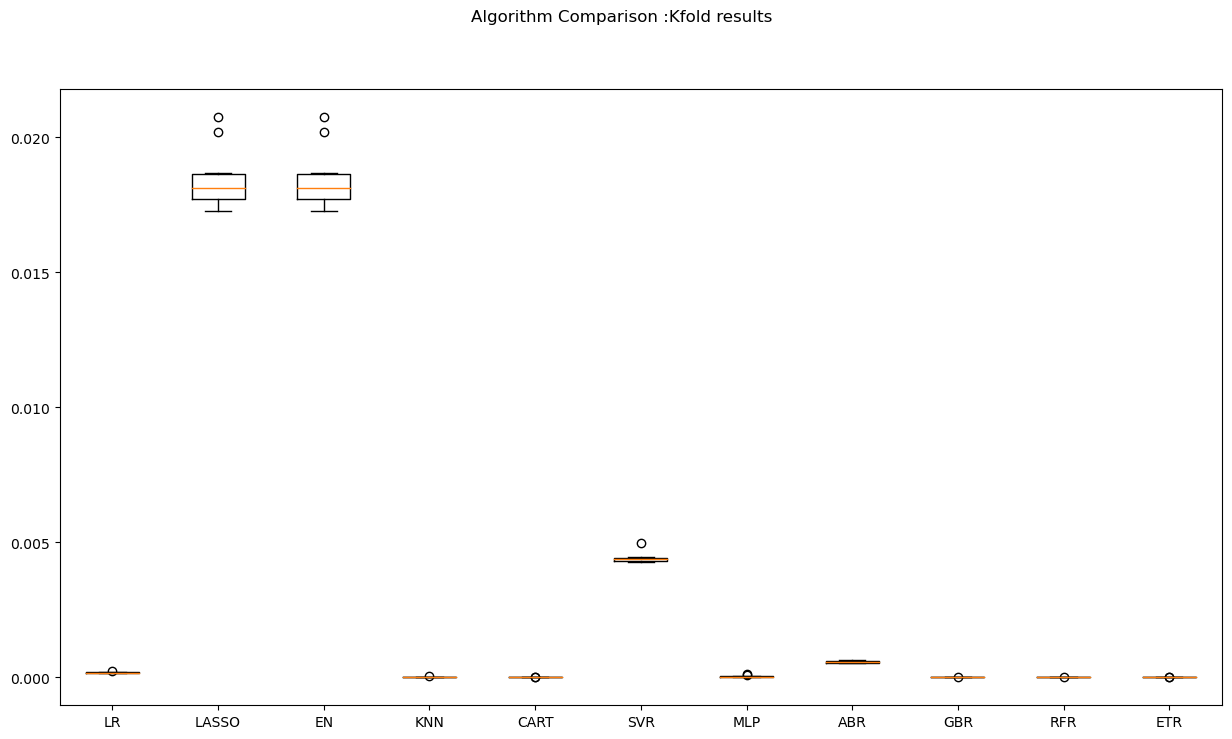

In [63]:
fig =pyplot.figure()
fig.suptitle('Algorithm Comparison :Kfold results')
ax =fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
#pyplot.xticks(names)
fig.set_size_inches(15,8)
pyplot.show()


In order to get a better view, we remove the LASSO and Elastic Net

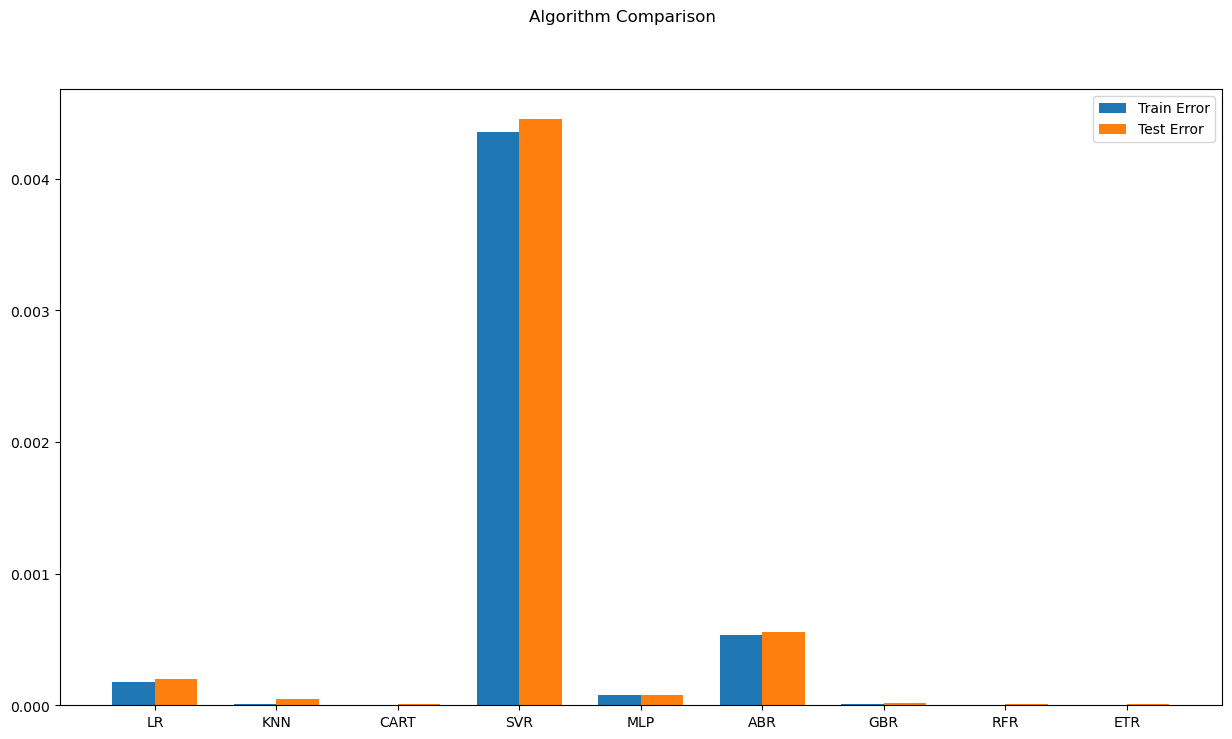

In [64]:

# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.

# 6. Model tuning and finalising the model


As shown in the chart above the MLP model is one of the best model, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.

In [66]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000042 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000347 (0.000106) with: {'hidden_layer_sizes': (20,)}
-0.000119 (0.000074) with: {'hidden_layer_sizes': (50,)}
-0.000105 (0.000084) with: {'hidden_layer_sizes': (20, 20)}
-0.000042 (0.000029) with: {'hidden_layer_sizes': (20, 30, 20)}


The best model is the model with 3 layers with 20, 30 and 20 nodes in each layer respectively.

In [67]:
model_tuned =MLPRegressor(hidden_layer_sizes=(20,30,20))
model_tuned.fit(X_train,Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [68]:
## estimate accuracy on validation set
# transform the validation dataset
predictions =model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

3.0359088229184997e-05



We see that the mean error (RMSE) is 3.03e-5 , which is less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.

# 7 . Additional analysis: removing the volatility data

Next, we make the process harder by trying to predict the price without the volatility data.

In [69]:
X =X[:,:2]

In [70]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [71]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [72]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [73]:

models.append(('MLP', MLPRegressor()))

In [74]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [76]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002510 (0.000150) 0.002506 0.002457
KNN: 0.000015 (0.000008) 0.000008 0.000044
CART: 0.000006 (0.000003) 0.000000 0.000012
SVR: 0.006194 (0.000135) 0.006126 0.006227
MLP: 0.000041 (0.000024) 0.000028 0.000026
ABR: 0.000597 (0.000024) 0.000585 0.000615
GBR: 0.000012 (0.000003) 0.000009 0.000020
RFR: 0.000002 (0.000003) 0.000000 0.000010
ETR: 0.000001 (0.000002) 0.000000 0.000008


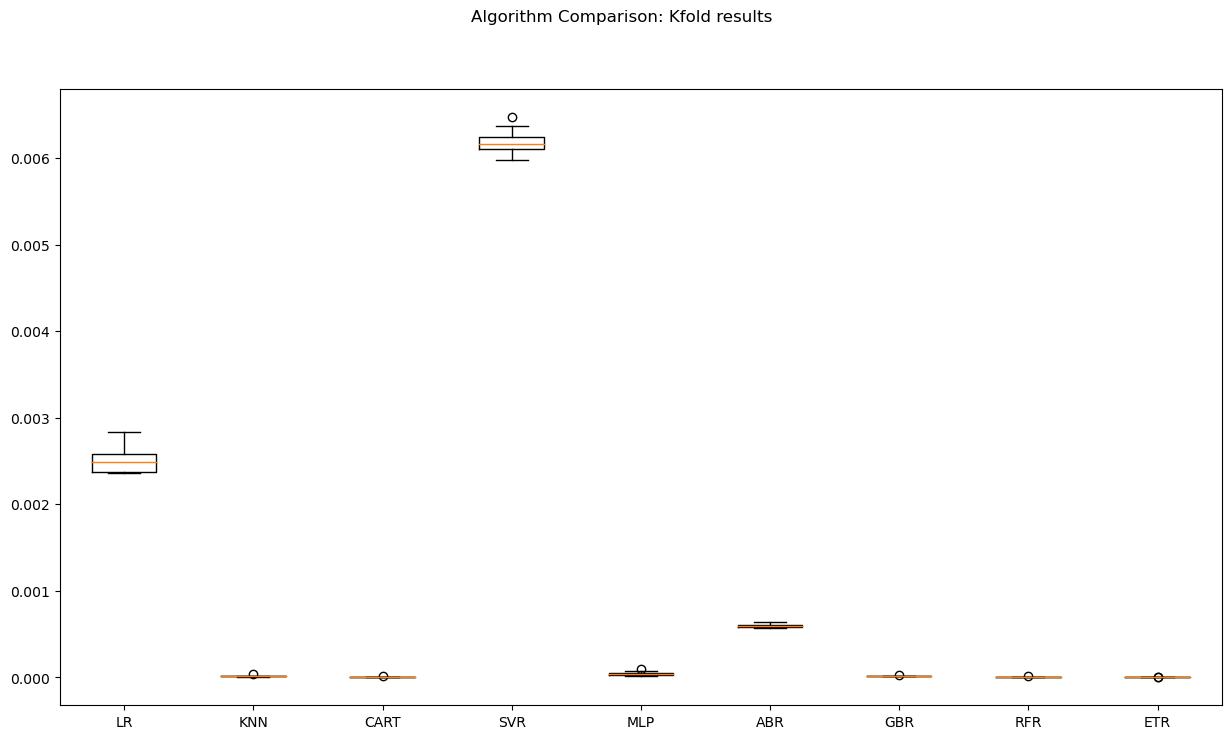

In [77]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

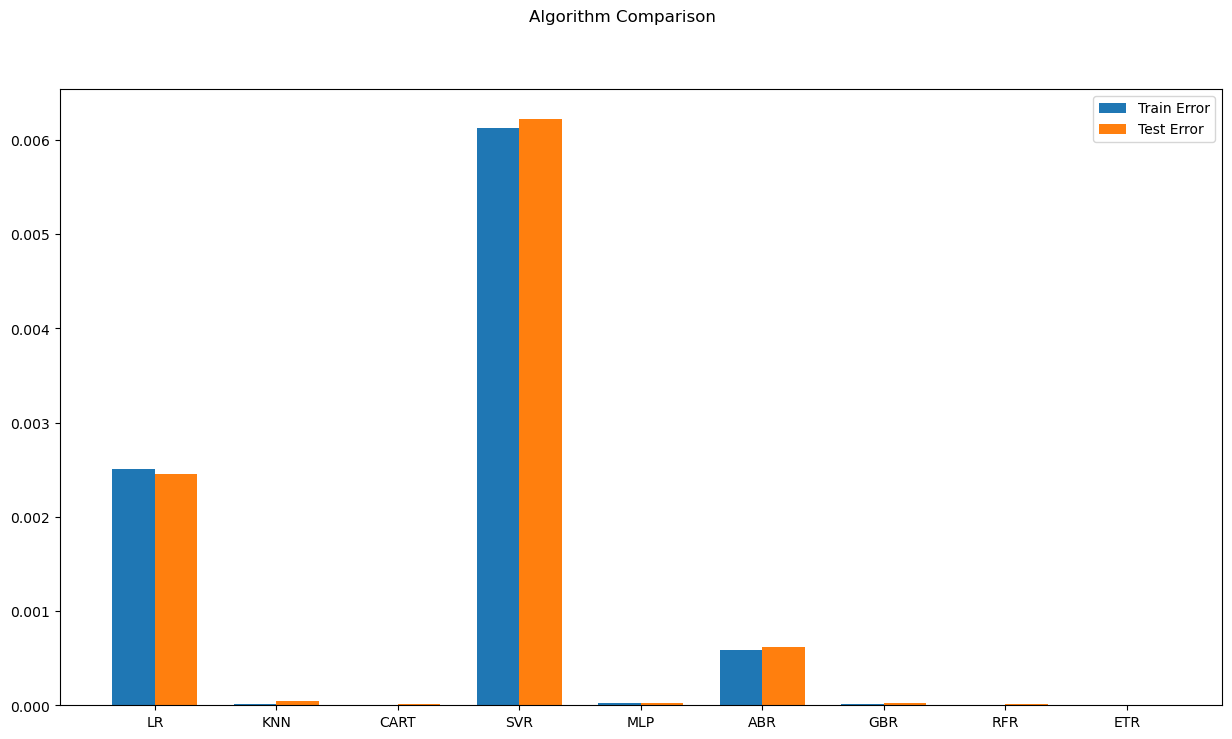

In [78]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

# Summary


- The linear regression model did not do as well as our non-linear models and  the non-linear models have a very good performance overall.

- Artificial neural network (ANN) can reproduce the Black and Scholes option pricing formula for a call option to a high degree of accuracy which means that we can leverage the efficient numerical calculation of machine learning in the derivative pricing without relying on the impractical assumptions made in the traditional derivative pricing models.